In [6]:
import os
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load yolo model from checkpoint
stigmas_model_checkpoint = "/home/etaylor/code_projects/thesis/checkpoints/stigmas_segmentation/yolo/fine_tuned/yolov8s_seg_fine_tuned.pt"

model = YOLO(stigmas_model_checkpoint)

In [7]:
import ultralytics
print(ultralytics.__version__)


8.3.56


In [8]:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/experiment_1/images/day_3_2024_06_06/greenhouse/67/IMG_5310.JPG"

image_numer = os.path.basename(image_path).split(".")[0].split("/")[-1]

print(f"Inference for image {image_numer}")

# Load the image
image = cv2.imread(image_path)

# Assuming 'model' is already loaded and 'image' is defined
# Perform inference
results = model.predict(image)

# Extract the first result
result = results[0]

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Inference for image IMG_5310



0: 480x640 16 stigmas, 145.2ms
Speed: 3.8ms preprocess, 145.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


In [9]:
def extract_segmented_objects(image_rgb, result, save_dir=None):
    masks = result.masks.data.cpu().numpy()  # Extract masks
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes for cropping

    if len(masks) == 0:
        print("No objects detected.")
        return []

    extracted_segments = []

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i, mask in enumerate(masks):
        # 🛠️ Ensure the mask is the same size as the image and of type uint8
        resized_mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))
        binary_mask = (resized_mask > 0.5).astype(np.uint8)  # Convert to binary mask

        # Apply the mask to the image
        segmented_object = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

        # Crop using bounding box for precise object extraction
        x_min, y_min, x_max, y_max = map(int, boxes[i])
        cropped_object = segmented_object[y_min:y_max, x_min:x_max]
        extracted_segments.append(cropped_object)

        # Save the segmented object if save_dir is provided
        if save_dir:
            save_path = os.path.join(save_dir, f'segment_{i + 1}.png')
            cv2.imwrite(save_path, cv2.cvtColor(cropped_object, cv2.COLOR_RGB2BGR))
            print(f"Saved segmented object: {save_path}")

    return extracted_segments

# Visualize extracted segmented objects
def visualize_segmented_objects(segmented_objects):
    if not segmented_objects:
        print("No segmented objects to display.")
        return

    fig, axes = plt.subplots(1, len(segmented_objects), figsize=(16, 8))
    for idx, obj in enumerate(segmented_objects):
        if len(segmented_objects) > 1:
            axes[idx].imshow(obj)
            axes[idx].set_title(f'Segment {idx + 1}')
            axes[idx].axis('off')
        else:
            axes.imshow(obj)
            axes.set_title(f'Segment {idx + 1}')
            axes.axis('off')

    plt.tight_layout()
    plt.show()


Inference for image day_4_IMG_5942

0: 480x640 16 stigmas, 7.1ms
Speed: 9.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


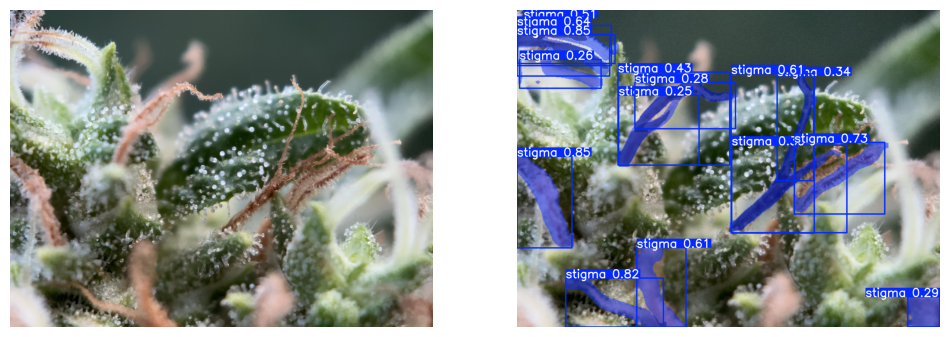

In [14]:
image_path = "/home/etaylor/code_projects/thesis/segments/etaylor_stigmas_dataset/yolo_formatted/images/val/day_4_IMG_5942.jpg"

image_numer = os.path.basename(image_path).split(".")[0].split("/")[-1]

print(f"Inference for image {image_numer}")

# Load the image
image = cv2.imread(image_path)

# Assuming 'model' is already loaded and 'image' is defined
# Perform inference
results = model.predict(image)

# Extract the first result
result = results[0]

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Plot the results
annotated_image = results[0].plot()

# convet the image to RGB
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(image_rgb)
axes[0].axis('off')

# Plot the annotated image
axes[1].imshow(annotated_image)
axes[1].axis('off')

plt.show()

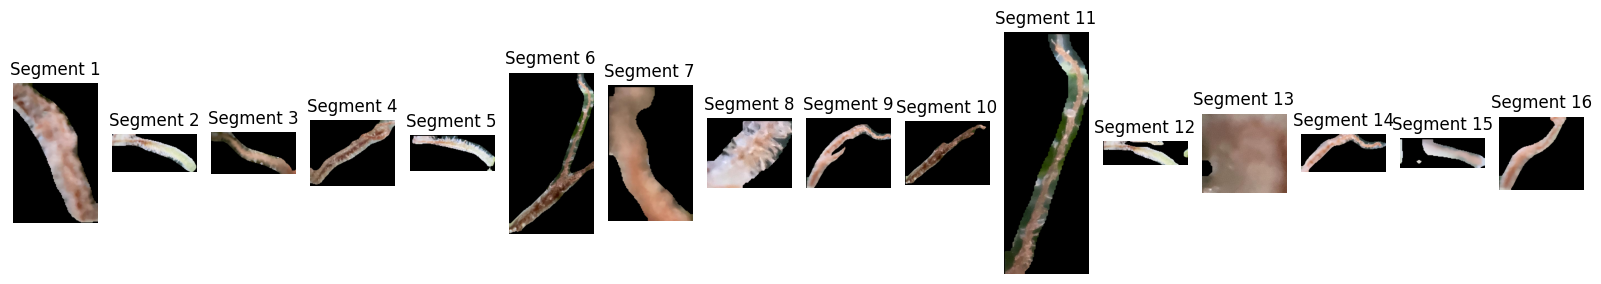

In [15]:
# Extract and visualize segmented objects
# extarcted_stigmas_dir = "/home/etaylor/code_projects/thesis/src/stigmas_detection/segmentation/yolo/extracted_stigmas"
# image_extracted_stigmas_dir = os.path.join(extarcted_stigmas_dir, image_numer)
segmented_objects = extract_segmented_objects(image_rgb, result)
visualize_segmented_objects(segmented_objects)

In [24]:
# 1) Remove green background -> get 'stigma_extracted'
# 2) Convert that to grayscale to find how many non-black pixels remain
for i in range(len(segmented_objects)):
    pistil = segmented_objects[i]
    stigma_gray = cv2.cvtColor(pistil, cv2.COLOR_RGB2GRAY)
    total_stigma_pixels = np.count_nonzero(stigma_gray)

    # 3) Convert to HSV
    hsv = cv2.cvtColor(pistil, cv2.COLOR_RGB2HSV)

    # 4) Threshold for orange
    lower_orange = np.array([0,  50,  50], dtype=np.uint8)
    upper_orange = np.array([40, 255, 255], dtype=np.uint8)
    orange_mask = cv2.inRange(hsv, lower_orange, upper_orange)

    # 5) Count how many of those stigma pixels are orange
    orange_pixels = np.count_nonzero(orange_mask)

    # 6) Compute ratio
    orange_ratio = orange_pixels / float(total_stigma_pixels) if total_stigma_pixels else 0

    print(f"Pistil {i + 1}")
    print(f"Orange ratio: {orange_ratio:.2f}")


Pistil 1
Orange ratio: 0.19
Pistil 2
Orange ratio: 0.95
Pistil 3
Orange ratio: 0.43
Pistil 4
Orange ratio: 0.45
Pistil 5
Orange ratio: 0.81
Pistil 6
Orange ratio: 0.68
Pistil 7
Orange ratio: 0.93
Pistil 8
Orange ratio: 0.38
Pistil 9
Orange ratio: 0.48
Pistil 10
Orange ratio: 0.94
Pistil 11
Orange ratio: 0.16
Pistil 12
Orange ratio: 0.34
Pistil 13
Orange ratio: 0.70
Pistil 14
Orange ratio: 0.60
Pistil 15
Orange ratio: 0.99
Pistil 16
Orange ratio: 0.00
Pistil 17
Orange ratio: 0.83


🔍 **Refined Stigma Extraction Strategy**
 ----------------------------------------- 

 ### **Color Filtering Within the Mask** 
   * **Problem**: Surrounding green areas blend with immature stigmas. 
   * **Solution**: Apply **color filtering** only within segmented regions to remove non-stigma green areas. 




In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def classify_stigma_colors(segmented_object):
    """
    Classifies pixels of a stigma into green, white, or orange with a priority order:
    1) Orange
    2) White
    3) Green
    
    This ensures no overlap among the three masks, so their ratios won't double-count.
    """
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(segmented_object, cv2.COLOR_RGB2HSV)

    # Define color ranges (tweak these as needed!)
    # -- GREEN
    lower_green = np.array([25,  30,  30], dtype=np.uint8)
    upper_green = np.array([95, 255, 255], dtype=np.uint8)

    # -- WHITE
    lower_white = np.array([0,  0, 220], dtype=np.uint8)
    upper_white = np.array([180, 30, 255], dtype=np.uint8)

    # -- ORANGE
    lower_orange = np.array([0,  50,  50], dtype=np.uint8)
    upper_orange = np.array([40, 255, 255], dtype=np.uint8)

    # Create raw masks
    green_mask_raw = cv2.inRange(hsv_image, lower_green, upper_green)
    white_mask_raw = cv2.inRange(hsv_image, lower_white, upper_white)
    orange_mask_raw = cv2.inRange(hsv_image, lower_orange, upper_orange)

    # Morphological cleanup (optional)
    kernel = np.ones((3, 3), np.uint8)
    green_mask_raw = cv2.morphologyEx(green_mask_raw, cv2.MORPH_CLOSE, kernel)
    white_mask_raw = cv2.morphologyEx(white_mask_raw, cv2.MORPH_CLOSE, kernel)
    orange_mask_raw = cv2.morphologyEx(orange_mask_raw, cv2.MORPH_CLOSE, kernel)

    #----------------------------------------------------
    # 1) ORANGE-EXCLUSIVE
    #----------------------------------------------------
    orange_exclusive = orange_mask_raw.copy()  # highest priority => take them as orange

    #----------------------------------------------------
    # 2) WHITE-EXCLUSIVE
    #    = white_mask_raw but only in pixels NOT already classified as orange
    #----------------------------------------------------
    not_orange = cv2.bitwise_not(orange_exclusive)
    white_exclusive = cv2.bitwise_and(white_mask_raw, not_orange)

    #----------------------------------------------------
    # 3) GREEN-EXCLUSIVE
    #    = green_mask_raw but only in pixels not already orange or white
    #----------------------------------------------------
    orange_or_white = cv2.bitwise_or(orange_exclusive, white_exclusive)
    not_orange_or_white = cv2.bitwise_not(orange_or_white)
    green_exclusive = cv2.bitwise_and(green_mask_raw, not_orange_or_white)

    #----------------------------------------------------
    # (Optional) Combine to define "total" as the union of green/white/orange
    #----------------------------------------------------
    total_union = cv2.bitwise_or(orange_exclusive,
                cv2.bitwise_or(white_exclusive, green_exclusive))
    total_pixels = cv2.countNonZero(total_union)

    # If you prefer to define "total" as the entire stigma region (including colors not in G/W/O),
    # you can do something like:
    #   stigma_gray = cv2.cvtColor(segmented_object, cv2.COLOR_RGB2GRAY)
    #   total_pixels = np.count_nonzero(stigma_gray)
    #
    # Then your color ratios will NOT necessarily sum to 1 if some pixels don't match G/W/O.
    #
    # For now, let's assume we only care about the union of G/W/O.

    #----------------------------------------------------
    # Count exclusive pixels
    #----------------------------------------------------
    orange_count = cv2.countNonZero(orange_exclusive)
    white_count  = cv2.countNonZero(white_exclusive)
    green_count  = cv2.countNonZero(green_exclusive)

    #----------------------------------------------------
    # Compute ratios
    #----------------------------------------------------
    if total_pixels > 0:
        orange_ratio = orange_count / float(total_pixels)
        white_ratio  = white_count  / float(total_pixels)
        green_ratio  = green_count  / float(total_pixels)
    else:
        orange_ratio = 0
        white_ratio  = 0
        green_ratio  = 0

    #----------------------------------------------------
    # Debug: visualize masks if you want
    #----------------------------------------------------
    # (1) Show raw vs. exclusive
    # fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    # axes[0,0].imshow(orange_mask_raw, cmap='gray'); axes[0,0].set_title("Orange Raw")
    # axes[0,1].imshow(white_mask_raw,  cmap='gray'); axes[0,1].set_title("White Raw")
    # axes[0,2].imshow(green_mask_raw,  cmap='gray'); axes[0,2].set_title("Green Raw")
    # axes[1,0].imshow(orange_exclusive,cmap='gray'); axes[1,0].set_title("Orange Exclusive")
    # axes[1,1].imshow(white_exclusive, cmap='gray'); axes[1,1].set_title("White Exclusive")
    # axes[1,2].imshow(green_exclusive, cmap='gray'); axes[1,2].set_title("Green Exclusive")
    # plt.tight_layout()
    # plt.show()

    return green_ratio, white_ratio, orange_ratio


def classify_stigma_kmeans(segmented_object, n_clusters=3):
    # Reshape the image to a 2D array of pixels
    img_data = segmented_object.reshape((-1, 3))

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(img_data)

    # Replace pixels with their cluster centers
    clustered_img = kmeans.cluster_centers_[kmeans.labels_].reshape(segmented_object.shape).astype(np.uint8)

    # Plot the result
    plt.imshow(clustered_img)
    plt.title("K-Means Color Clustering")
    plt.axis('off')
    plt.show()

    # Count the number of pixels in each cluster
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    ratios = counts / counts.sum()

    return ratios

# Helper function to display images side by side
def show_images(images, titles, figsize=(20, 10)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Apply color filtering to extract stigma and remove green background
def apply_color_filter(segmented_object):
    hsv_image = cv2.cvtColor(segmented_object, cv2.COLOR_RGB2HSV)

    # Define HSV ranges for green, white, and orange
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])

    # Create color masks
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Remove green background
    stigma_mask = cv2.bitwise_not(green_mask)

    return stigma_mask

# Apply the mask to extract the stigma
def apply_mask_on_image(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

# Full pipeline to extract stigma, classify colors, and plot results
def full_pipeline(segmented_object):
    # 1. Remove green background
    stigma_mask = apply_color_filter(segmented_object)
    
    # 2. Extract stigma
    stigma_extracted = apply_mask_on_image(segmented_object, stigma_mask)
    
    # 3. Classify stigma colors
    green_ratio, white_ratio, orange_ratio = classify_stigma_colors(stigma_extracted)
    
    # 4. Display results
    color_distribution = (
        f"Green Ratio: {green_ratio * 100:.2f}%\n"
        f"White Ratio: {white_ratio * 100:.2f}%\n"
        f"Orange Ratio: {orange_ratio * 100:.2f}%"
    )

    show_images(
        [segmented_object, stigma_extracted],
        ['Original Segmented Object', f'Stigma without Green Background\n{color_distribution}'],
        figsize=(12, 6)
    )

    return green_ratio, white_ratio, orange_ratio


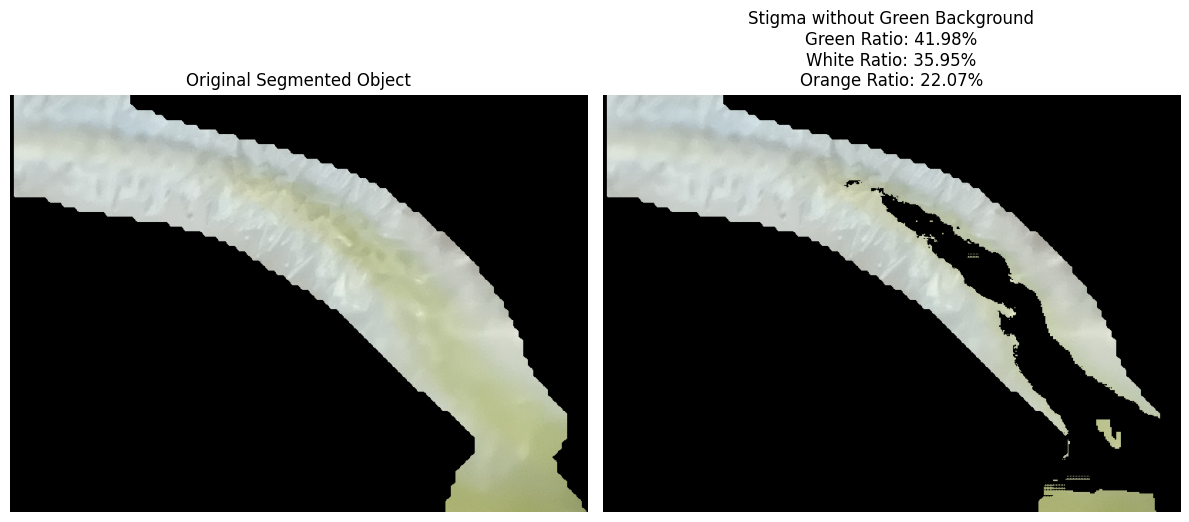

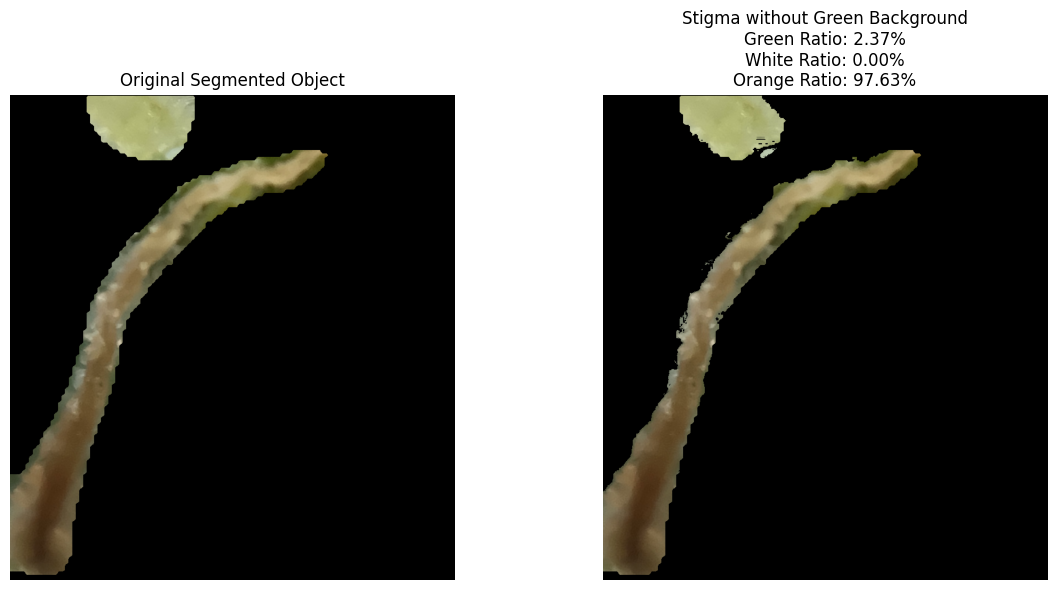

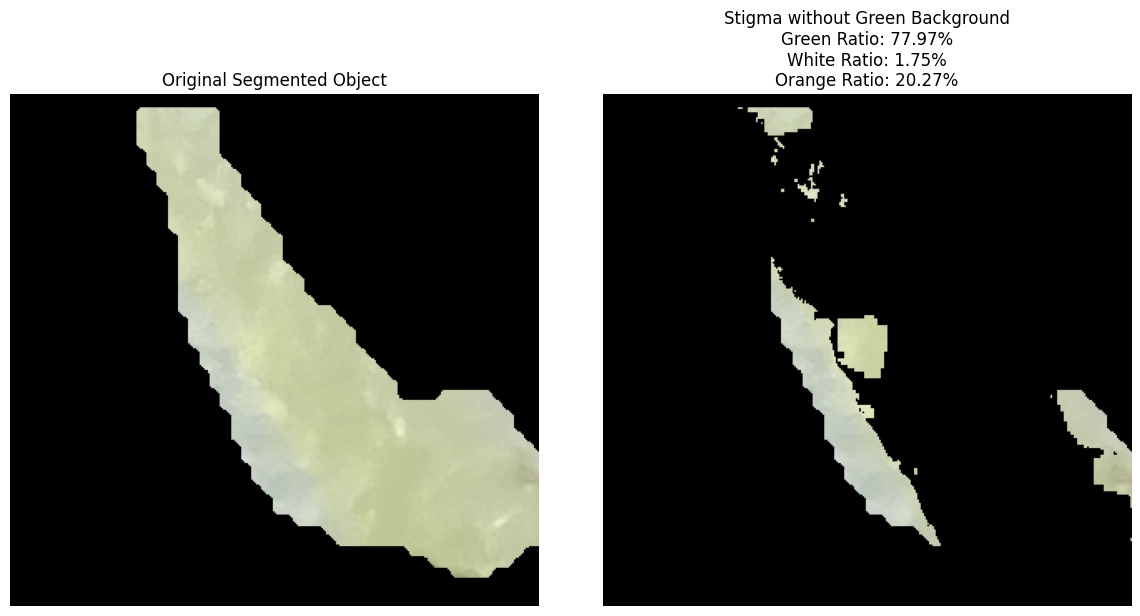

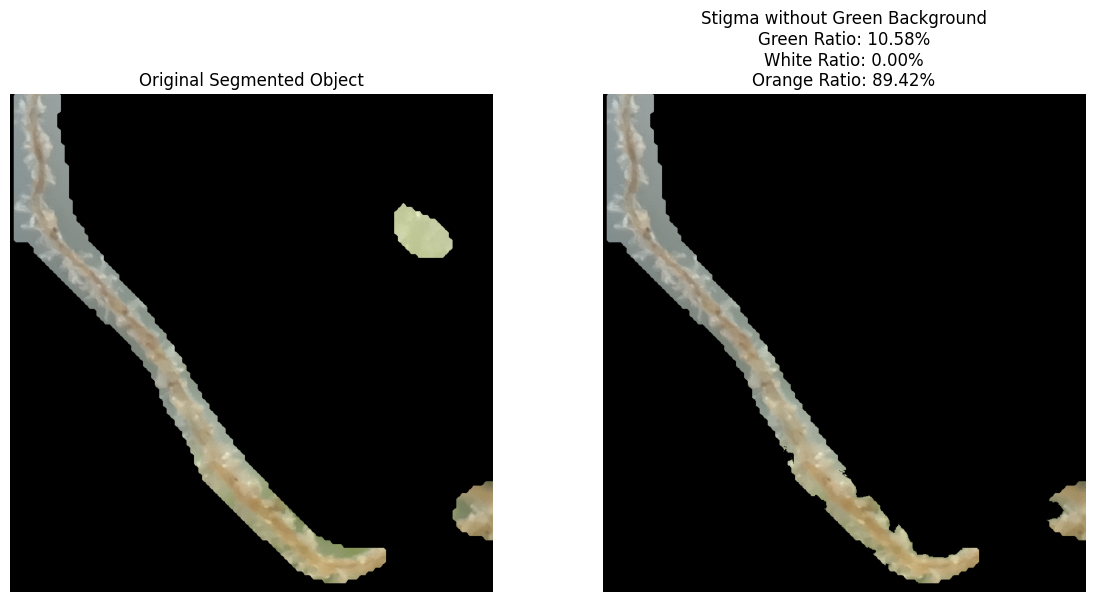

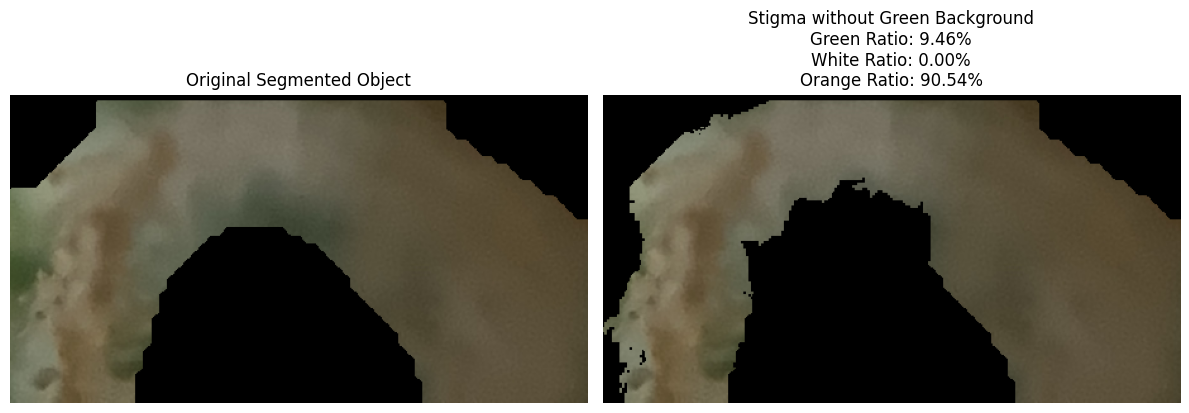

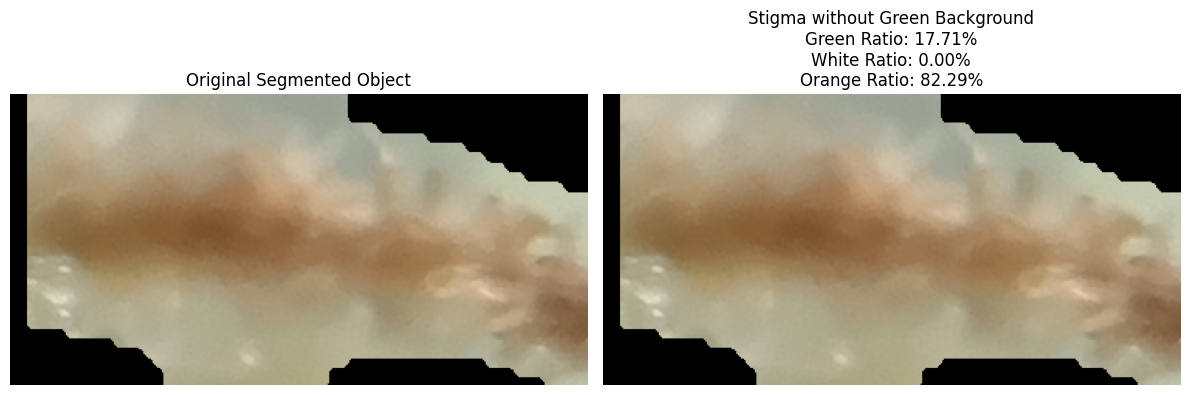

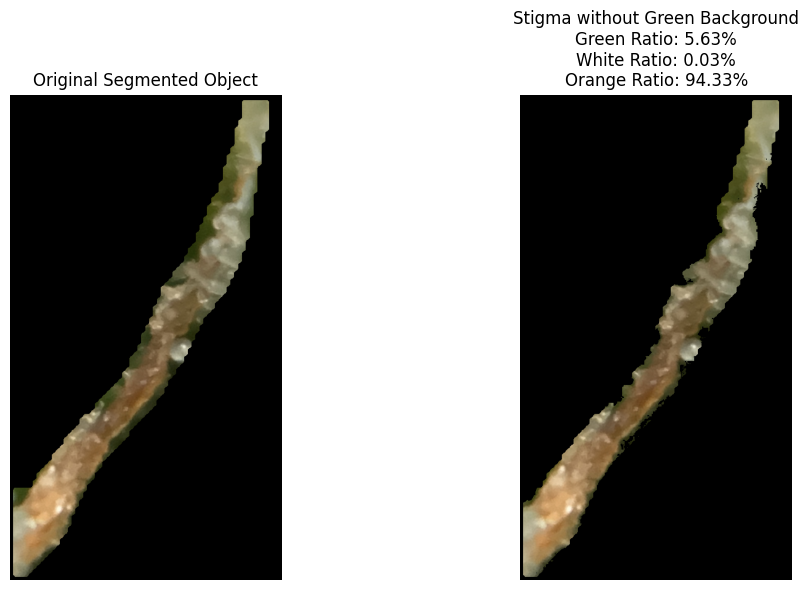

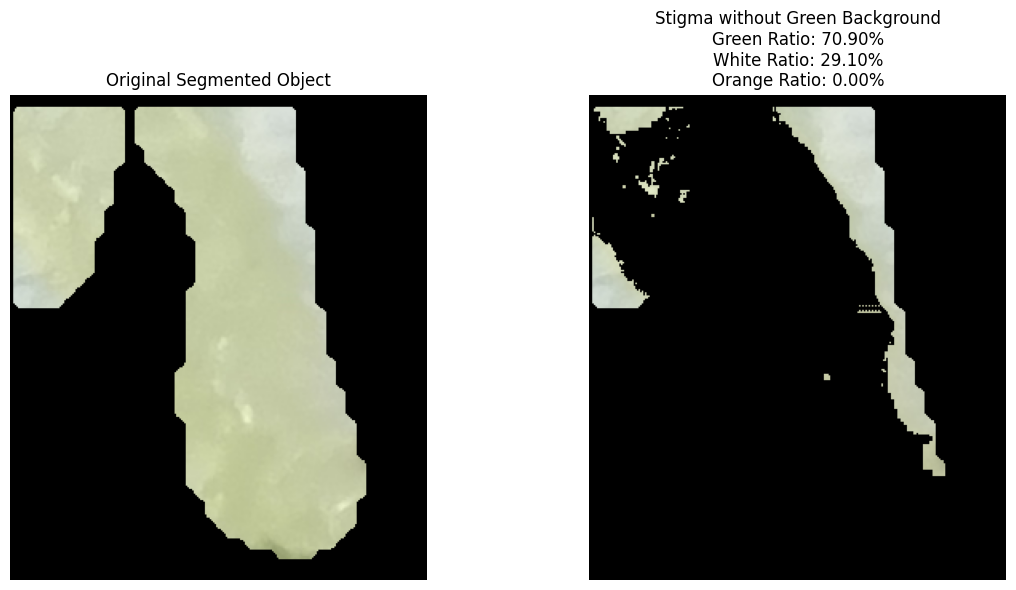

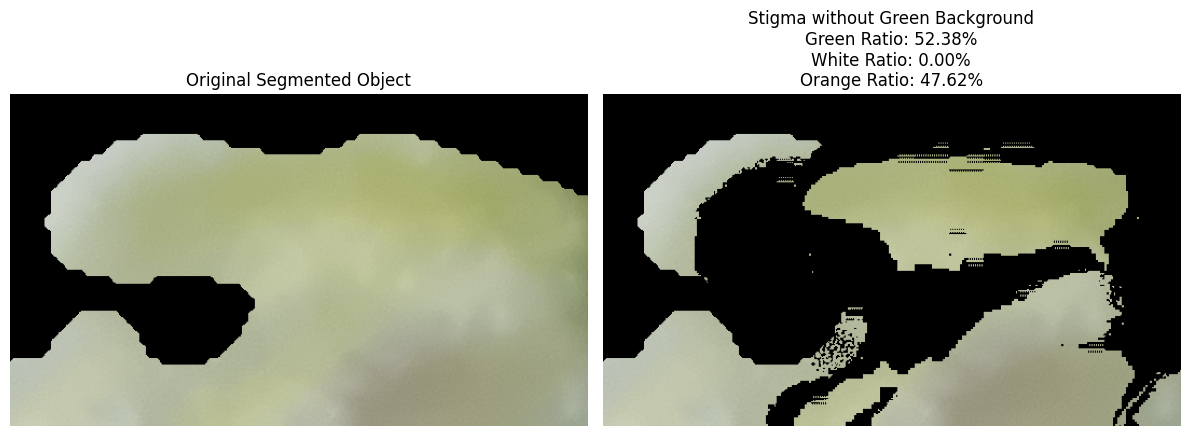

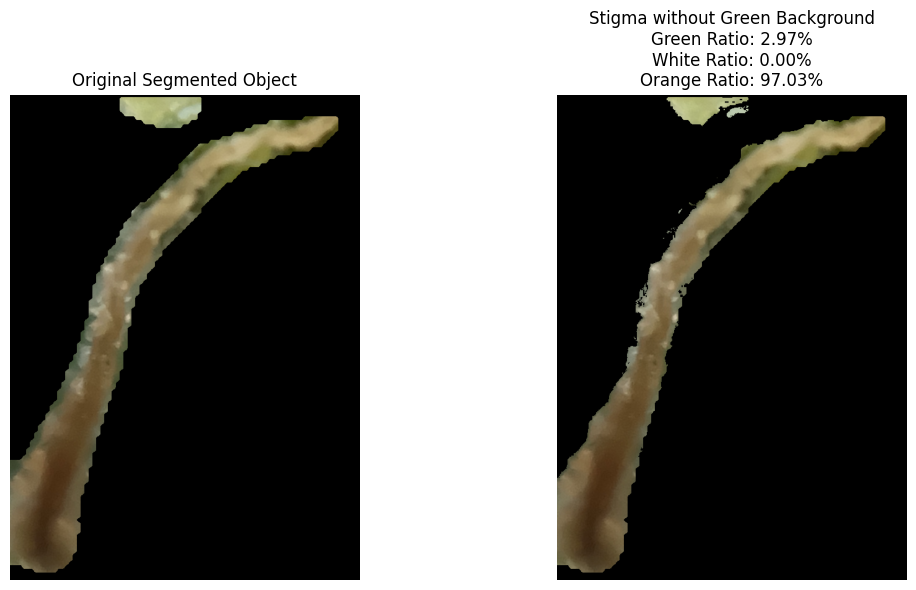

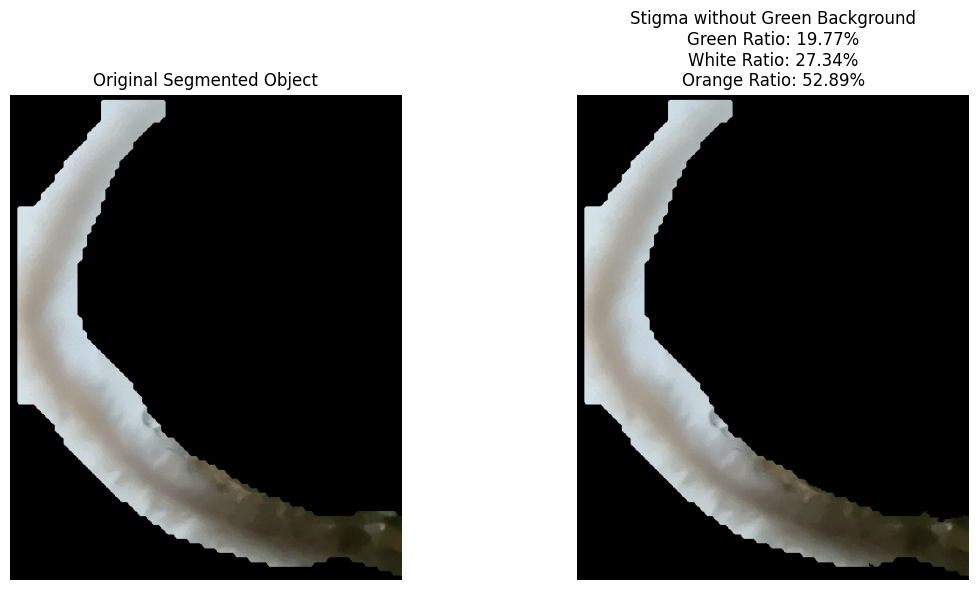

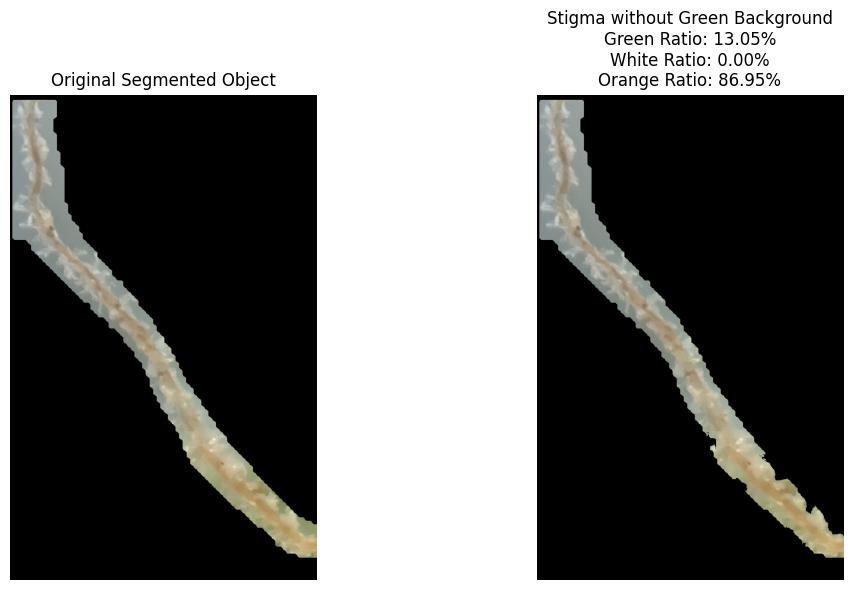

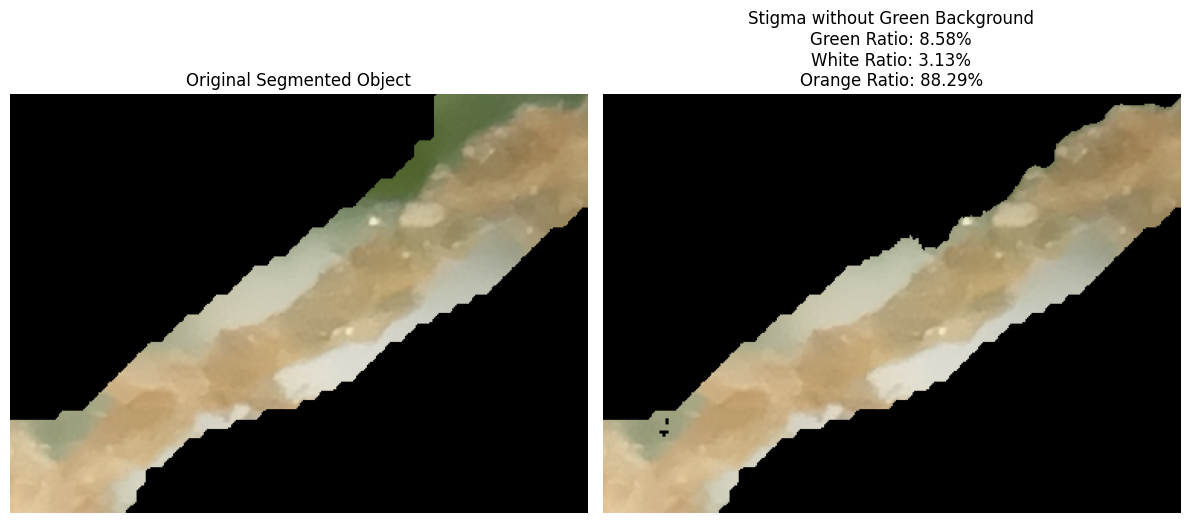

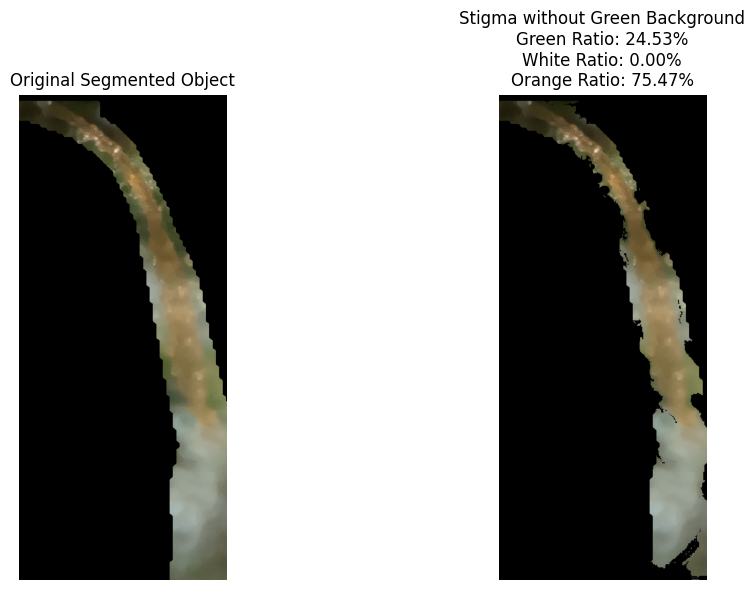

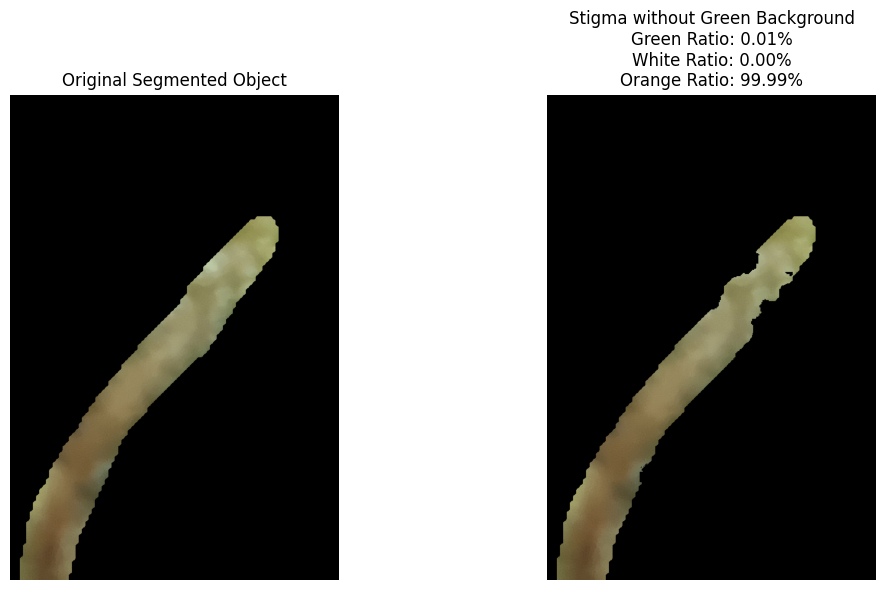

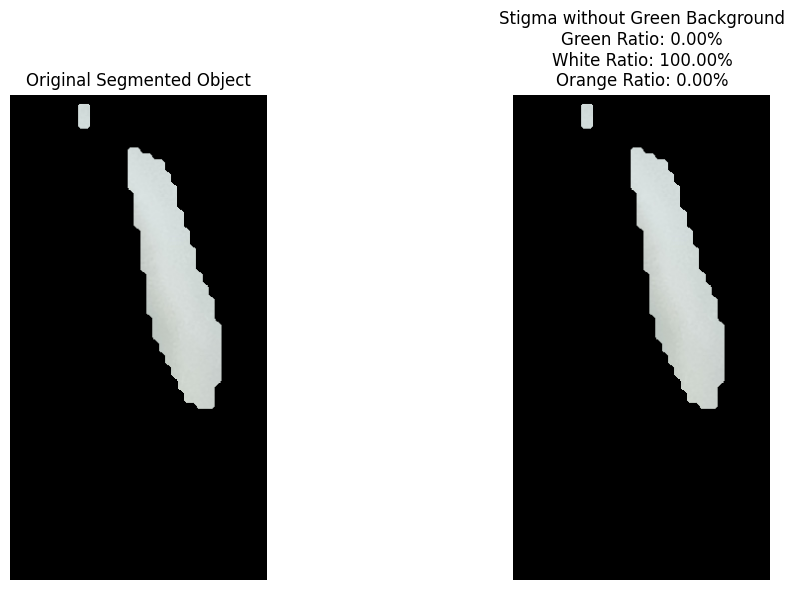

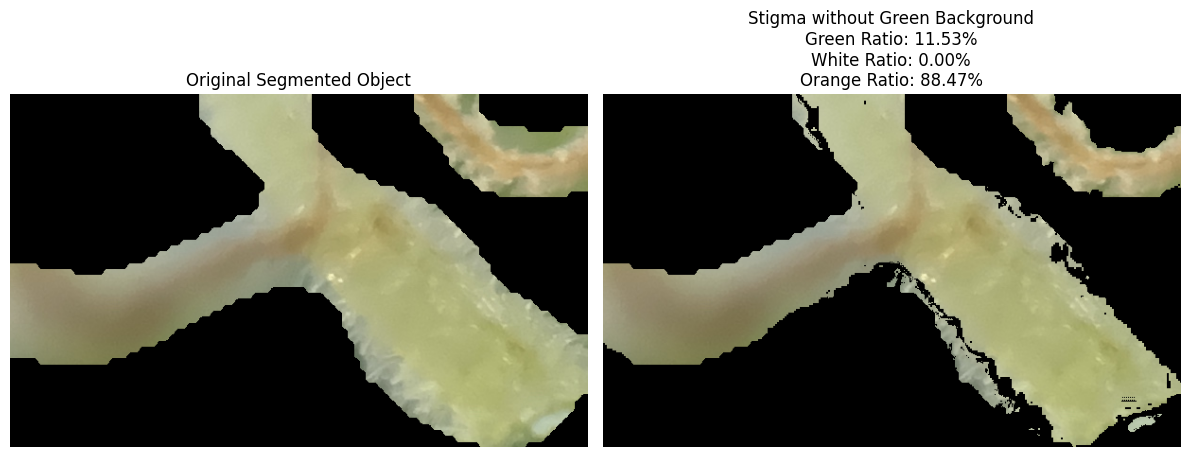

In [28]:
# Function to process all images in a folder
def process_folder_images(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            if image is not None:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                full_pipeline(image_rgb)


# Process and plot all images in the folder
process_folder_images(image_extracted_stigmas_dir)


## 🔍 Enhanced Background Removal Strategies
1. **K-means Clustering for Color Segmentation:**
This method segments the image into clusters and isolates non-green regions.

2. **GrabCut Algorithm:**
A more advanced background subtraction method that intelligently separates the foreground (stigma) from the background.

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Helper function to display images side by side
def show_images(images, titles, figsize=(20, 10)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Method 1: K-means Clustering for Background Removal
def kmeans_background_removal(image, k=2):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((image.shape))

    # Assume the background cluster is the most dominant
    mask = (labels.reshape((image.shape[:2])) == np.argmax(np.bincount(labels.flatten()))).astype(np.uint8) * 255
    mask = cv2.bitwise_not(mask)
    return cv2.bitwise_and(image, image, mask=mask)

# Method 2: GrabCut Algorithm for Background Removal
def grabcut_background_removal(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, image.shape[1]-10, image.shape[0]-10)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    return image * mask2[:, :, np.newaxis]

# Function to process and compare both methods
def process_and_compare_methods(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            if image is not None:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply K-means and GrabCut methods
                kmeans_result = kmeans_background_removal(image_rgb)
                grabcut_result = grabcut_background_removal(image_rgb)

                # Plot original, K-means, and GrabCut results
                show_images(
                    [image_rgb, kmeans_result, grabcut_result],
                    [f'Original - {filename}', 'K-means Background Removal', 'GrabCut Background Removal'],
                    figsize=(15, 5)
                )


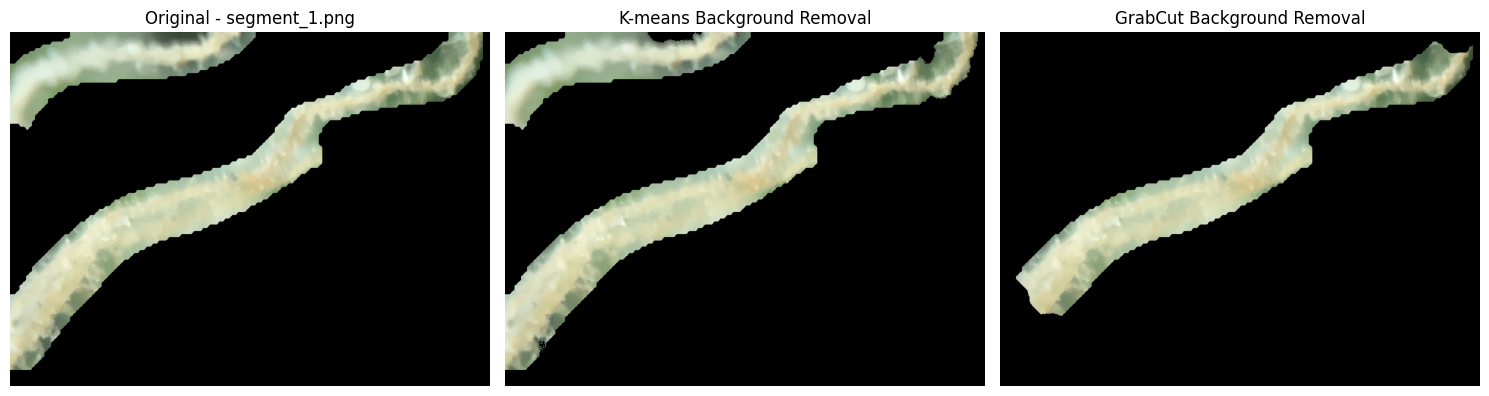

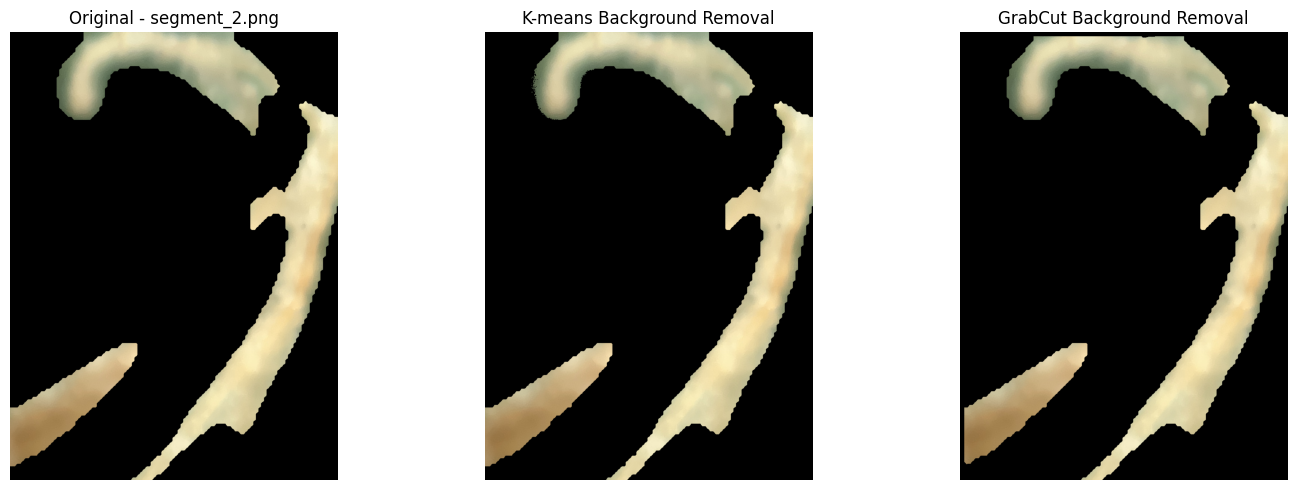

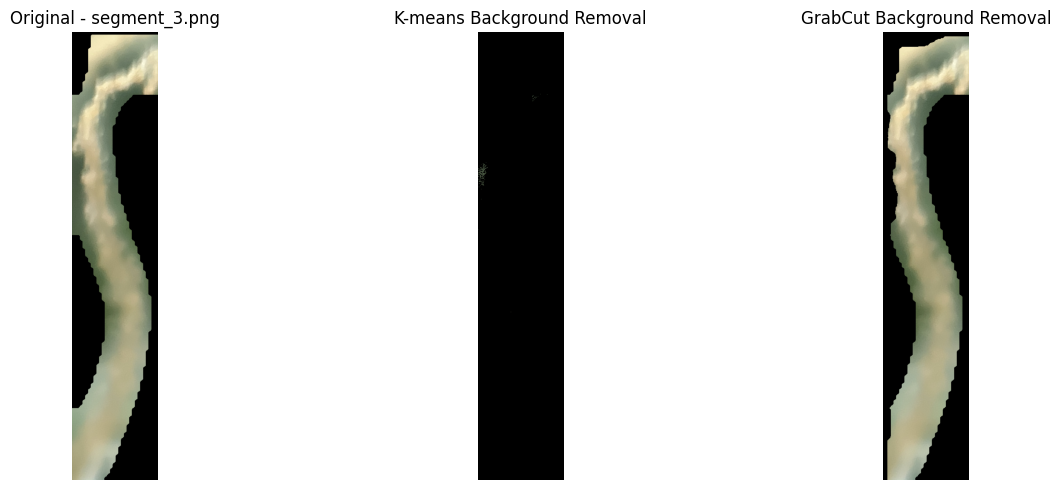

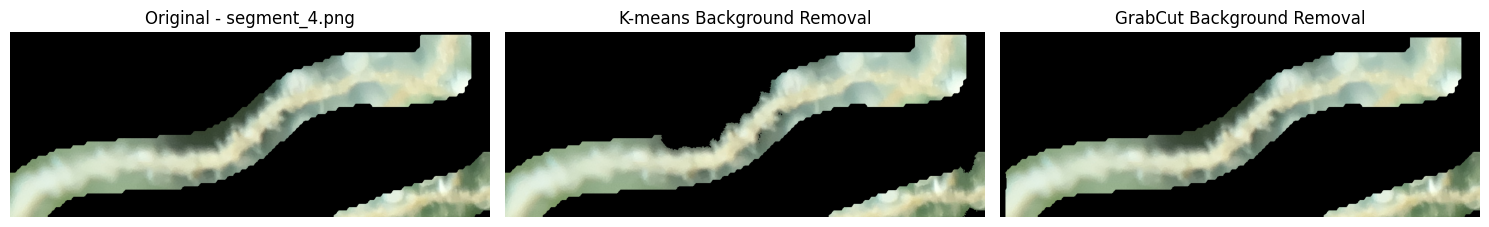

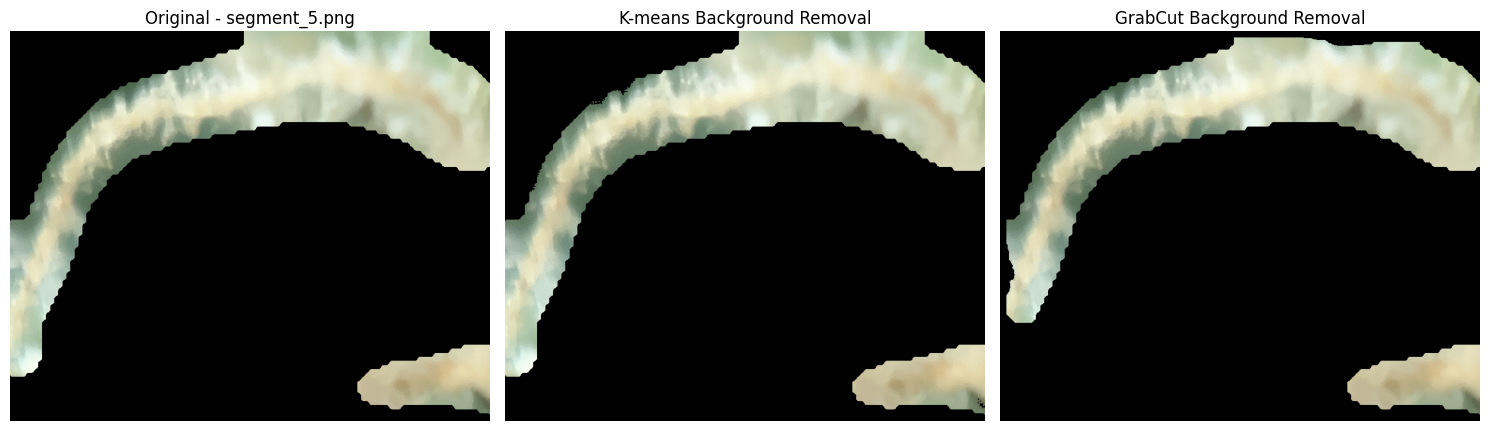

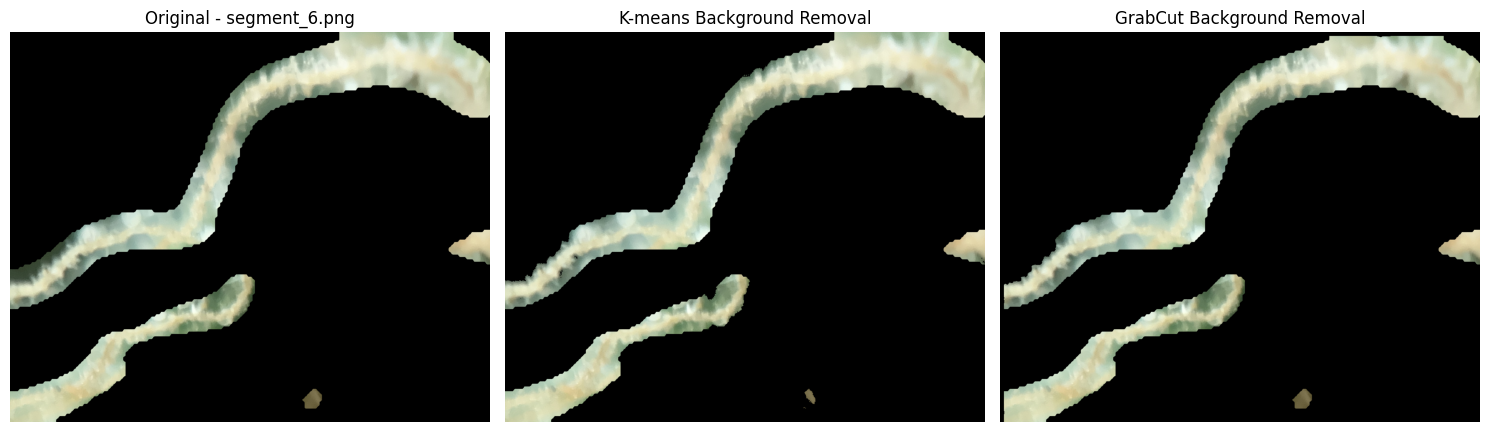

In [6]:
# Folder path containing the segmented stigma images
folder_path = "/home/etaylor/code_projects/thesis/segmented_stigmas"

# Process and compare the results of both methods
process_and_compare_methods(folder_path)

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def msrcr_retinex(img_bgr, sigma_list=[15, 80, 250], G=5, b=25, alpha=125, beta=46):
    """
    Multi-Scale Retinex with Color Restoration (MSRCR).
    This is a simplified example; you can find more robust implementations online.
    """
    # Convert to floating point
    img = img_bgr.astype(np.float32) + 1.0

    # 1) Retinex
    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        # Gaussian blur
        blur = cv2.GaussianBlur(img, (0, 0), sigma)
        # Log-based Retinex
        retinex += np.log10(img) - np.log10(blur + 1.0)

    retinex = retinex / len(sigma_list)

    # 2) Color Restoration
    #  CRF = alpha * (img / sum(img per pixel))^beta
    #  Then multiply retinex by CRF
    sum_rgb = np.sum(img, axis=2, keepdims=True)
    c = alpha * ((img / (sum_rgb + 1e-6)) ** beta)
    msrcr = c * retinex

    # 3) Simple normalization to [0, 255]
    msrcr = msrcr - msrcr.min()
    msrcr = msrcr / msrcr.max()
    msrcr = (msrcr * 255.0).astype(np.uint8)

    # 4) Apply final gain/offset
    # Optionally you can adjust gain and offset for better brightness/contrast.
    return msrcr

def retinex_color_correction(segmented_object_rgb):
    # Convert RGB -> BGR for typical OpenCV usage
    seg_bgr = cv2.cvtColor(segmented_object_rgb, cv2.COLOR_RGB2BGR)
    corrected_bgr = msrcr_retinex(seg_bgr)
    corrected_rgb = cv2.cvtColor(corrected_bgr, cv2.COLOR_BGR2RGB)
    return corrected_rgb

def to_rg_chromaticity(rgb_img):
    # rgb_img in [0..255], shape (H, W, 3)
    # Output: (r, g) in float, ignoring black background
    float_img = rgb_img.astype(np.float32) + 1e-6
    R = float_img[:,:,0]
    G = float_img[:,:,1]
    B = float_img[:,:,2]

    sum_ = R + G + B
    r = R / sum_
    g = G / sum_
    return r, g



def classify_stigma_colors_histogram(segmented_object_rgb,
                                     debug=False,
                                     white_balance=False,
                                     single_peak_tolerance=5,
                                     min_peak_height_ratio=0.05):
    """
    Classify a segmented pistil as green/orange by analyzing the hue histogram.
    - If only one significant peak is found, the entire pistil is assigned that color.
    - If two peaks are found, the hue range is split at the valley between them.
    
    Args:
        segmented_object_rgb (np.ndarray): RGB image of the pistil.
        debug (bool): If True, show debug plots for the histogram and masks.
        white_balance (bool): If True, apply a simple white-balance correction before processing.
        single_peak_tolerance (int): If the two peaks are closer than this in hue-space, treat as one color.
        min_peak_height_ratio (float): The minimum peak height (as a fraction of the max histogram value) 
                                       to consider a peak "significant".
    Returns:
        (orange_ratio, green_ratio) in [0, 1].
    """
    
    def simple_white_balance(img_rgb):
        """
        A quick LAB-based white balance to reduce strong color casts.
        Feel free to replace with your own or skip if not needed.
        """
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        balanced = cv2.merge((l, a, b))
        return cv2.cvtColor(balanced, cv2.COLOR_LAB2RGB)

    # 1) Optional white balance
    if white_balance:
        segmented_object_rgb = simple_white_balance(segmented_object_rgb)

    # 2) Convert to HSV
    hsv = cv2.cvtColor(segmented_object_rgb, cv2.COLOR_RGB2HSV)
    h_channel, s_channel, v_channel = cv2.split(hsv)

    # 3) Mask out black background (or near-black)
    gray = cv2.cvtColor(segmented_object_rgb, cv2.COLOR_RGB2GRAY)
    foreground_mask = (gray > 10)  # keep pixels with intensity > 10
    foreground_indices = np.where(foreground_mask)

    # Edge case: if no foreground pixels, return zero ratios
    if len(foreground_indices[0]) == 0:
        return (0.0, 0.0)

    # Extract hue of foreground
    hue_fg = h_channel[foreground_mask]  # range [0..179] in OpenCV

    # 4) Build hue histogram
    num_bins = 180
    hist, bin_edges = np.histogram(hue_fg, bins=num_bins, range=(0, 180))

    # Normalize histogram so we can compare relative peak heights
    hist_max = hist.max() if hist.max() > 0 else 1
    hist_normalized = hist / float(hist_max)

    # 5) Detect peaks
    # We'll consider only peaks above min_peak_height_ratio of the max histogram
    peaks, properties = find_peaks(hist_normalized, height=min_peak_height_ratio)

    # Filter out any peaks that are too small
    # 'peaks' is an array of indices; 'properties["peak_heights"]' gives the normalized height
    significant_peaks = []
    for i, pk in enumerate(peaks):
        if properties["peak_heights"][i] >= min_peak_height_ratio:
            significant_peaks.append(pk)

    # Sort peaks by histogram value descending if needed
    # but typically find_peaks() already returns them in ascending x (hue).
    significant_peaks = np.array(significant_peaks)

    # (Optional) If more than 2 peaks are found, pick the top 2 by height
    if len(significant_peaks) > 2:
        # Sort by actual peak height descending
        sorted_idxs = np.argsort(properties["peak_heights"])[::-1]
        top2 = sorted_idxs[:2]
        significant_peaks = significant_peaks[top2]

    # 6) Decide how many peaks to use
    if len(significant_peaks) == 0:
        # No peak found above threshold => treat entire pistil as one color
        # We'll just look at the mean hue to decide
        mean_hue = hue_fg.mean()
        return classify_single_color(mean_hue)
    elif len(significant_peaks) == 1:
        # Only one peak => single color classification
        peak_hue = significant_peaks[0]
        return classify_single_color(peak_hue)
    else:
        # We have 2 significant peaks
        p1, p2 = sorted(significant_peaks)
        # If they are very close, treat as one color
        if abs(p1 - p2) < single_peak_tolerance:
            # single color
            avg_hue = 0.5 * (p1 + p2)
            return classify_single_color(avg_hue)
        else:
            # We have 2 distinct peaks => two colors
            # Find the valley between them to split the hue
            midpoint = (p1 + p2) // 2
            # We'll classify hue < midpoint => cluster 1, hue >= midpoint => cluster 2

            # But we still need to figure out which cluster is "orange" vs. "green."
            # We'll do it by computing the mean hue of each cluster and see which is bigger.
            cluster1_mask = (h_channel < midpoint) & foreground_mask
            cluster2_mask = (h_channel >= midpoint) & foreground_mask

            c1_hue = h_channel[cluster1_mask]
            c2_hue = h_channel[cluster2_mask]

            c1_mean = c1_hue.mean() if len(c1_hue) > 0 else 0
            c2_mean = c2_hue.mean() if len(c2_hue) > 0 else 0

            # Decide which is orange vs. green
            # Typically, orange is in ~10-30 range, green is ~35-85,
            # but it can vary with lighting. We'll just say the cluster
            # with the higher mean hue is "green" if it's near the 60ish range,
            # or "orange" if it's near the 20ish range.
            # We'll do a simpler approach: the cluster with the LOWER mean hue is orange, 
            # the HIGHER is green. (This is not universal, but works if your oranges < 35.)

            if c1_mean < c2_mean:
                # cluster1 => orange, cluster2 => green
                orange_count = cluster1_mask.sum()
                green_count = cluster2_mask.sum()
            else:
                # cluster1 => green, cluster2 => orange
                orange_count = cluster2_mask.sum()
                green_count = cluster1_mask.sum()

            total_pixels = orange_count + green_count
            if total_pixels == 0:
                return (0.0, 0.0)
            orange_ratio = orange_count / float(total_pixels)
            green_ratio = green_count / float(total_pixels)

            if debug:
                debug_plot(segmented_object_rgb, hist_normalized, significant_peaks, 
                           cluster1_mask, cluster2_mask, midpoint)
            
            return (orange_ratio, green_ratio)

def classify_single_color(hue_value):
    """
    Given a single hue value, decide if it's orange or green.
    Return (orange_ratio, green_ratio).
    """
    # Simple heuristic:
    # If hue < ~30 => orange
    # else => green
    if hue_value < 30:
        return (1.0, 0.0)  # 100% orange
    else:
        return (0.0, 1.0)  # 100% green

def debug_plot(segmented_object_rgb, hist_normalized, peaks, mask1, mask2, midpoint):
    """
    Debug visualization for histogram, peaks, and final masks.
    """
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    
    # Original segmented pistil
    axs[0,0].imshow(segmented_object_rgb)
    axs[0,0].set_title("Segmented Pistil (RGB)")
    axs[0,0].axis('off')

    # Hue histogram
    axs[0,1].plot(hist_normalized, color='blue')
    axs[0,1].set_title("Normalized Hue Histogram")
    axs[0,1].set_xlabel("Hue (0-179)")
    axs[0,1].set_ylabel("Normalized Frequency")
    for pk in peaks:
        axs[0,1].axvline(pk, color='red', linestyle='--', alpha=0.7)
    axs[0,1].axvline(midpoint, color='green', linestyle=':', alpha=0.8)

    # Cluster masks
    axs[1,0].imshow(mask1, cmap='gray')
    axs[1,0].set_title("Cluster 1 Mask")
    axs[1,0].axis('off')

    axs[1,1].imshow(mask2, cmap='gray')
    axs[1,1].set_title("Cluster 2 Mask")
    axs[1,1].axis('off')

    plt.tight_layout()
    plt.show()


In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt


def classify_stigma_colors_hsv(segmented_object, debug_masks=False):
    """
    Classifies pixels of a stigma into ORANGE or GREEN in HSV space,
    with ORANGE as the higher priority.
    Any pixel that qualifies for orange is labeled orange first,
    then green for the remaining pixels.
    """
    
    # --- Convert to HSV ---
    # Make sure 'segmented_object' is in RGB before converting;
    # if it's BGR, you must convert with cv2.COLOR_BGR2HSV instead.
    hsv_image = cv2.cvtColor(segmented_object, cv2.COLOR_RGB2HSV)
    
    # --- Define Thresholds ---
    # Recommended starting ranges for ORANGE and GREEN in HSV
    # (Hue range is 0-180 in OpenCV by default).
    # You can adjust these values after testing on real images.
    
    # ORANGE thresholds
    lower_orange = np.array([ 5,  60,  50], dtype=np.uint8)
    upper_orange = np.array([25, 255, 255], dtype=np.uint8)

    # GREEN thresholds
    lower_green = np.array([35,  60,  50], dtype=np.uint8)
    upper_green = np.array([85, 255, 255], dtype=np.uint8)
    
    # --- Create Raw Masks ---
    orange_mask_raw = cv2.inRange(hsv_image, lower_orange, upper_orange)
    green_mask_raw  = cv2.inRange(hsv_image, lower_green, upper_green)
    
    # --- Morphological Cleanup ---
    kernel = np.ones((3, 3), np.uint8)
    
    # Close small holes in each mask
    orange_mask_raw = cv2.morphologyEx(orange_mask_raw, cv2.MORPH_CLOSE, kernel)
    green_mask_raw  = cv2.morphologyEx(green_mask_raw,  cv2.MORPH_CLOSE, kernel)
    
    # Optionally open the green mask to remove small noise
    green_mask_raw  = cv2.morphologyEx(green_mask_raw,  cv2.MORPH_OPEN, kernel)
    
    # --- Debug: Visualize Raw Masks if Requested ---
    if debug_masks:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(orange_mask_raw, cmap='gray')
        axs[0].set_title('Orange Mask')
        axs[0].axis('off')
        
        axs[1].imshow(green_mask_raw, cmap='gray')
        axs[1].set_title('Green Mask')
        axs[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # --- Priority-based Assignment: Orange takes precedence ---
    orange_exclusive = orange_mask_raw.copy()
    not_orange       = cv2.bitwise_not(orange_exclusive)
    green_exclusive  = cv2.bitwise_and(green_mask_raw, not_orange)
    
    # --- Count Pixels in the Combined Regions ---
    total_union  = cv2.bitwise_or(orange_exclusive, green_exclusive)
    total_pixels = cv2.countNonZero(total_union)
    orange_count = cv2.countNonZero(orange_exclusive)
    green_count  = cv2.countNonZero(green_exclusive)
    
    # --- Compute Ratios ---
    orange_ratio = orange_count / float(total_pixels) if total_pixels > 0 else 0
    green_ratio  = green_count  / float(total_pixels) if total_pixels > 0 else 0
    
    return orange_ratio, green_ratio


def classify_stigma_colors_rgb(segmented_object_rgb, debug_masks=False):
    """
    Classify each pixel in an RGB image of a pistil as either "orange-brown" or "green"
    using simple RGB ranges and priority-based assignment:
    1) orange-brown first,
    2) then green for remaining pixels.
    """

    # -----------------------------
    # 1) Define color thresholds
    # -----------------------------
    #
    # If you find that the code still marks too many green areas as orange,
    # try narrowing the orange range further (especially the R range),
    # or require a smaller range of G/B so that only truly orange/brown pixels pass.
    #
    # Below is a starting point. Adjust as needed!

    # Orange-brown range (tighter than before)
    # - R must be fairly high, and G/B relatively lower.
    lower_orange = np.array([150,  60,   0], dtype=np.uint8)  # R >= 150, G >= 60, B >= 0
    upper_orange = np.array([255, 170, 120], dtype=np.uint8)  # R up to 255, G up to 170, B up to 120

    # Green range (slightly broader)
    # - We allow a decent range for R but require G to be high enough and B not too high.
    lower_green = np.array([0,   60,   0], dtype=np.uint8)    # R >= 0, G >= 60, B >= 0
    upper_green = np.array([180, 255, 180], dtype=np.uint8)   # R <= 180, G <= 255, B <= 180

    # -----------------------------
    # 2) Create raw masks in RGB
    # -----------------------------
    # NOTE: OpenCV’s cv2.inRange expects the image in the same channel order you have.
    # If `segmented_object_rgb` is truly RGB, this is correct. If BGR, convert first.
    orange_mask_raw = cv2.inRange(segmented_object_rgb, lower_orange, upper_orange)
    green_mask_raw  = cv2.inRange(segmented_object_rgb, lower_green,  upper_green)

    # -----------------------------
    # 3) Morphological cleanup
    # -----------------------------
    kernel = np.ones((3, 3), np.uint8)
    orange_mask_clean = cv2.morphologyEx(orange_mask_raw, cv2.MORPH_CLOSE, kernel)
    orange_mask_clean = cv2.morphologyEx(orange_mask_clean, cv2.MORPH_OPEN,  kernel)

    green_mask_clean  = cv2.morphologyEx(green_mask_raw,  cv2.MORPH_CLOSE, kernel)
    green_mask_clean  = cv2.morphologyEx(green_mask_clean, cv2.MORPH_OPEN,  kernel)

    # -----------------------------
    # 4) Priority-based assignment
    #    (Orange first, then green)
    # -----------------------------
    orange_exclusive = orange_mask_clean.copy()
    not_orange       = cv2.bitwise_not(orange_exclusive)
    green_exclusive  = cv2.bitwise_and(green_mask_clean, not_orange)

    # -----------------------------
    # 5) Count the pixels
    # -----------------------------
    total_union  = cv2.bitwise_or(orange_exclusive, green_exclusive)
    total_pixels = cv2.countNonZero(total_union)
    orange_count = cv2.countNonZero(orange_exclusive)
    green_count  = cv2.countNonZero(green_exclusive)

    if total_pixels == 0:
        return (0.0, 0.0)

    orange_ratio = orange_count / float(total_pixels)
    green_ratio  = green_count  / float(total_pixels)

    # -----------------------------
    # 6) Debug visualization
    # -----------------------------
    if debug_masks:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(segmented_object_rgb)
        axs[0].set_title('Segmented Pistil (RGB)')
        axs[0].axis('off')

        axs[1].imshow(orange_exclusive, cmap='gray')
        axs[1].set_title('Orange-Brown Mask')
        axs[1].axis('off')

        axs[2].imshow(green_exclusive, cmap='gray')
        axs[2].set_title('Green Mask')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    return (orange_ratio, green_ratio)


def run_stigma_segmentation_pipeline(image_path, model, save_dir=None, debug_masks=False):
    # 1) Load and run YOLO
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image from {image_path}")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.predict(image)
    result = results[0]

    # 2) Visualize original vs. annotated
    annotated_image = result.plot()  # BGR
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(annotated_image)
    axes[1].set_title("Annotated Image")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    # 3) Extract segmented pistils
    def extract_segmented_objects(image_rgb, result, save_dir=None):
        if result.masks is None:
            print("No segmentation masks found in the result.")
            return []
        masks = result.masks.data.cpu().numpy()  
        boxes = result.boxes.xyxy.cpu().numpy()
        if len(masks) == 0:
            print("No objects detected.")
            return []

        extracted_segments = []
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        for i, mask in enumerate(masks):
            resized_mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))
            binary_mask  = (resized_mask > 0.5).astype(np.uint8)
            segmented_object = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

            x_min, y_min, x_max, y_max = map(int, boxes[i])
            cropped_object = segmented_object[y_min:y_max, x_min:x_max]

            extracted_segments.append(cropped_object)
            if save_dir:
                save_path = os.path.join(save_dir, f'segment_{i+1}.png')
                cv2.imwrite(save_path, cv2.cvtColor(cropped_object, cv2.COLOR_RGB2BGR))
                print(f"Saved segmented object: {save_path}")

        return extracted_segments

    image_basename = os.path.splitext(os.path.basename(image_path))[0]
    image_extracted_stigmas_dir = os.path.join(save_dir, image_basename) if save_dir else None
    segmented_objects = extract_segmented_objects(image_rgb, result, save_dir=image_extracted_stigmas_dir)

    # 4) Visualize segmented pistils
    def visualize_segmented_objects(segmented_objects):
        if not segmented_objects:
            print("No segmented objects to display.")
            return
        fig, axes = plt.subplots(1, len(segmented_objects), figsize=(16, 8))
        if len(segmented_objects) == 1:
            axes = [axes]
        for idx, obj in enumerate(segmented_objects):
            axes[idx].imshow(obj)
            axes[idx].set_title(f'Segment {idx + 1}')
            axes[idx].axis('off')
        plt.tight_layout()
        plt.show()

    visualize_segmented_objects(segmented_objects)

    # 5) Classify in RGB
    for i, pistil in enumerate(segmented_objects, start=1):
        orange_ratio, green_ratio = classify_stigma_colors_rgb(pistil, debug_masks=debug_masks)
        print(f"\nPistil {i} Color Ratios (RGB):")
        print(f"  Orange-Brown: {orange_ratio * 100:.2f}%")
        print(f"  Green:        {green_ratio * 100:.2f}%")

    return segmented_objects





0: 480x640 11 stigmas, 36.2ms
Speed: 18.3ms preprocess, 36.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


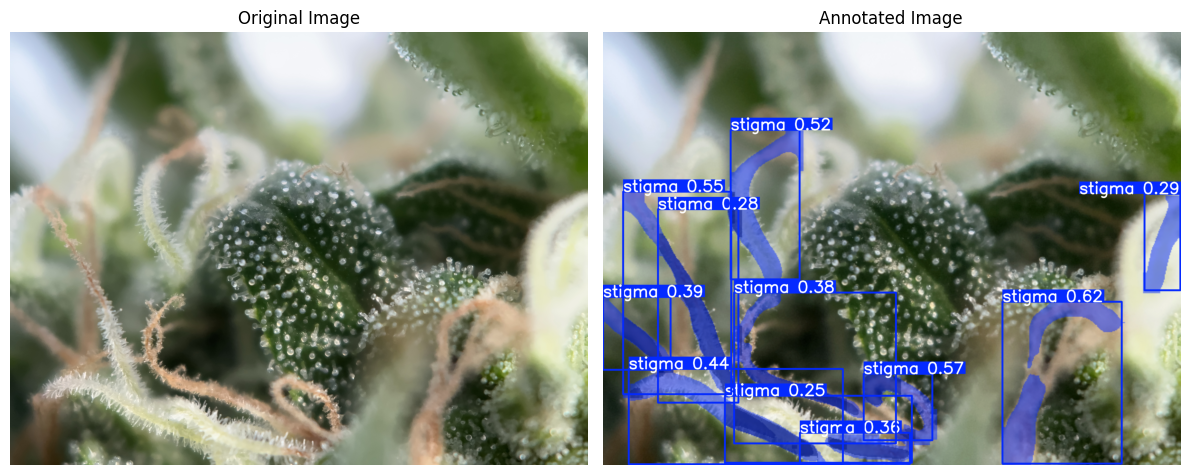

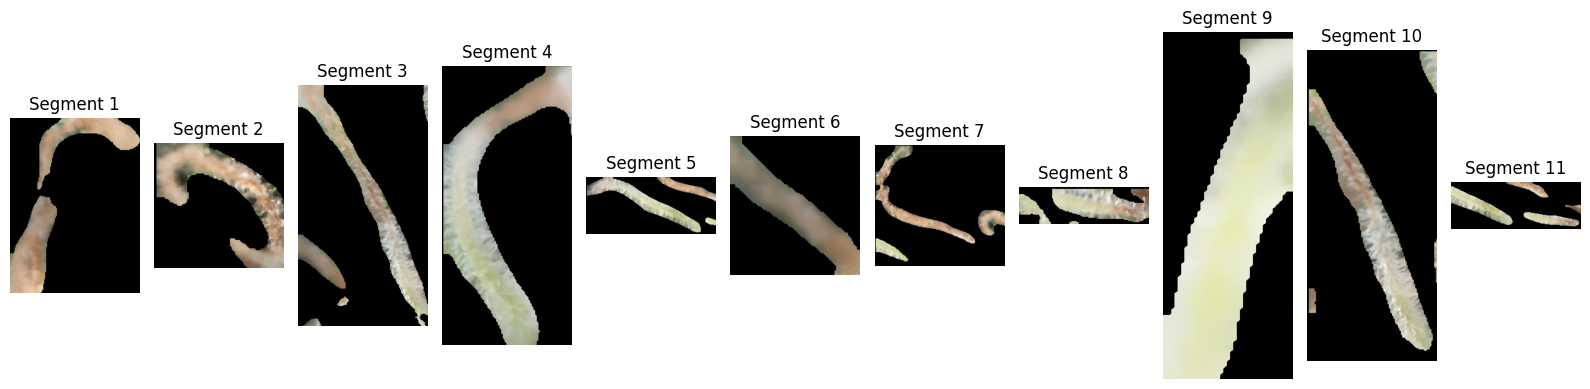


Pistil 1 Color Ratios (RGB):
  Orange-Brown: 44.58%
  Green:        55.42%

Pistil 2 Color Ratios (RGB):
  Orange-Brown: 20.00%
  Green:        80.00%

Pistil 3 Color Ratios (RGB):
  Orange-Brown: 11.72%
  Green:        88.28%

Pistil 4 Color Ratios (RGB):
  Orange-Brown: 4.35%
  Green:        95.65%

Pistil 5 Color Ratios (RGB):
  Orange-Brown: 12.87%
  Green:        87.13%

Pistil 6 Color Ratios (RGB):
  Orange-Brown: 16.94%
  Green:        83.06%

Pistil 7 Color Ratios (RGB):
  Orange-Brown: 22.64%
  Green:        77.36%

Pistil 8 Color Ratios (RGB):
  Orange-Brown: 7.04%
  Green:        92.96%

Pistil 9 Color Ratios (RGB):
  Orange-Brown: 0.00%
  Green:        100.00%

Pistil 10 Color Ratios (RGB):
  Orange-Brown: 11.17%
  Green:        88.83%

Pistil 11 Color Ratios (RGB):
  Orange-Brown: 17.08%
  Green:        82.92%


In [23]:
# Example usage:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/experiment_1/images/day_3_2024_06_06/greenhouse/67/IMG_5312.JPG"

# `model` is your loaded YOLO model
segmented_objects = run_stigma_segmentation_pipeline(
    image_path=image_path,
    model=model,
)



0: 480x640 14 stigmas, 14.6ms
Speed: 3.1ms preprocess, 14.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


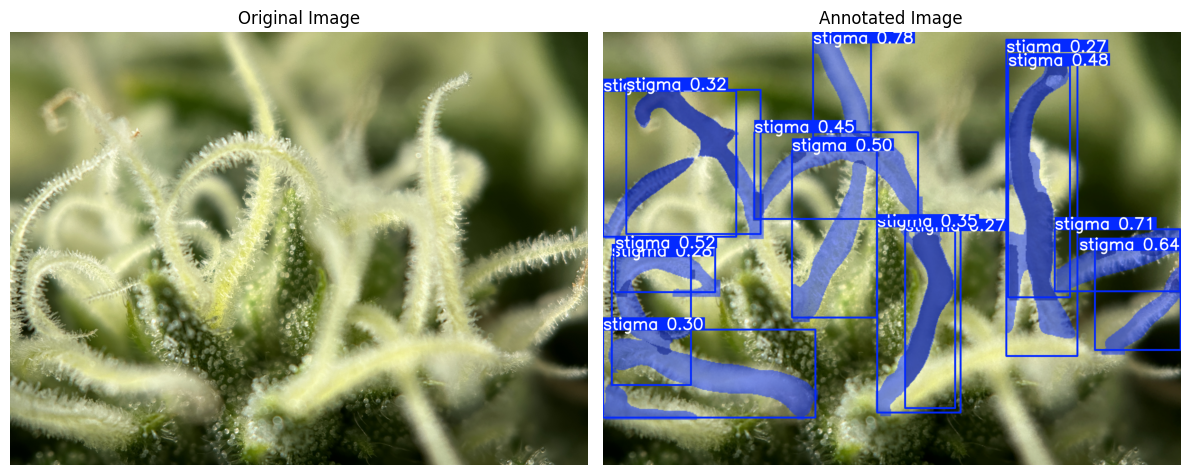

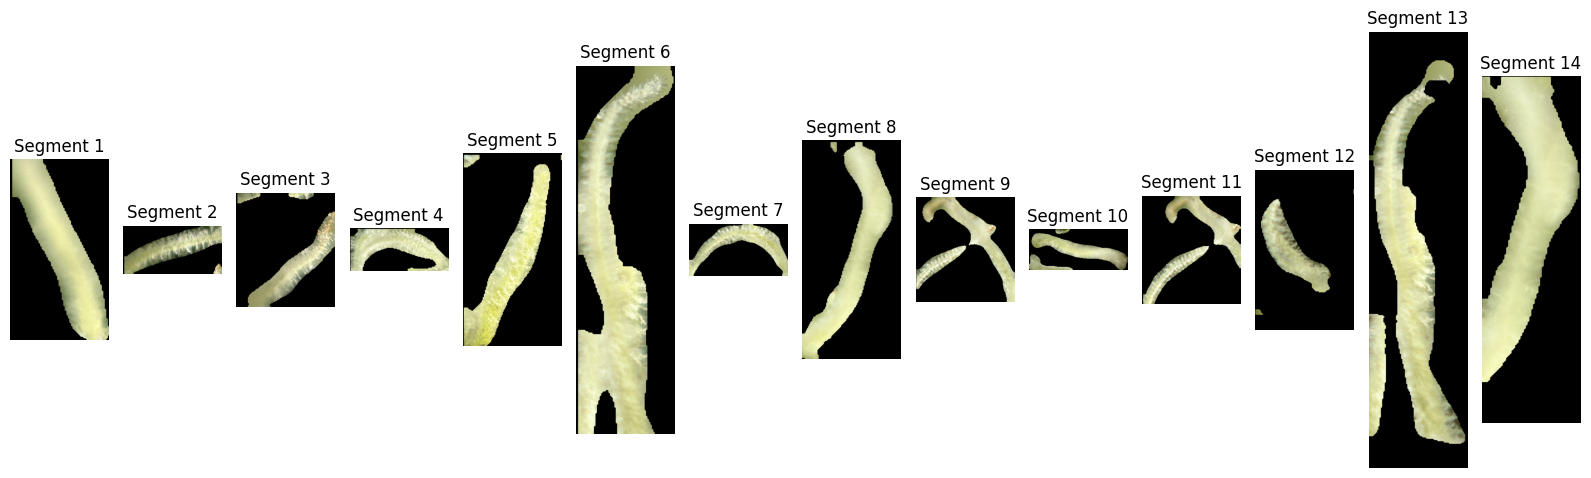


Pistil 1 Color Ratios (RGB):
  Orange-Brown: 0.00%
  Green:        100.00%

Pistil 2 Color Ratios (RGB):
  Orange-Brown: 7.86%
  Green:        92.14%

Pistil 3 Color Ratios (RGB):
  Orange-Brown: 67.99%
  Green:        32.01%

Pistil 4 Color Ratios (RGB):
  Orange-Brown: 14.45%
  Green:        85.55%

Pistil 5 Color Ratios (RGB):
  Orange-Brown: 2.81%
  Green:        97.19%

Pistil 6 Color Ratios (RGB):
  Orange-Brown: 1.33%
  Green:        98.67%

Pistil 7 Color Ratios (RGB):
  Orange-Brown: 15.83%
  Green:        84.17%

Pistil 8 Color Ratios (RGB):
  Orange-Brown: 0.17%
  Green:        99.83%

Pistil 9 Color Ratios (RGB):
  Orange-Brown: 64.22%
  Green:        35.78%

Pistil 10 Color Ratios (RGB):
  Orange-Brown: 4.23%
  Green:        95.77%

Pistil 11 Color Ratios (RGB):
  Orange-Brown: 62.31%
  Green:        37.69%

Pistil 12 Color Ratios (RGB):
  Orange-Brown: 22.75%
  Green:        77.25%

Pistil 13 Color Ratios (RGB):
  Orange-Brown: 3.52%
  Green:        96.48%

Pistil 14 Col

In [20]:
# Example usage:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/experiment_1/images/day_1_2024_05_30/greenhouse/08/IMG_5003.JPG"
segmented_stigmas_save_dir = "/path/to/save/segmented_pistils"

# `model` is your loaded YOLO model
segmented_objects = run_stigma_segmentation_pipeline(
    image_path=image_path,
    model=model,
)


0: 480x640 12 stigmas, 84.3ms
Speed: 17.5ms preprocess, 84.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


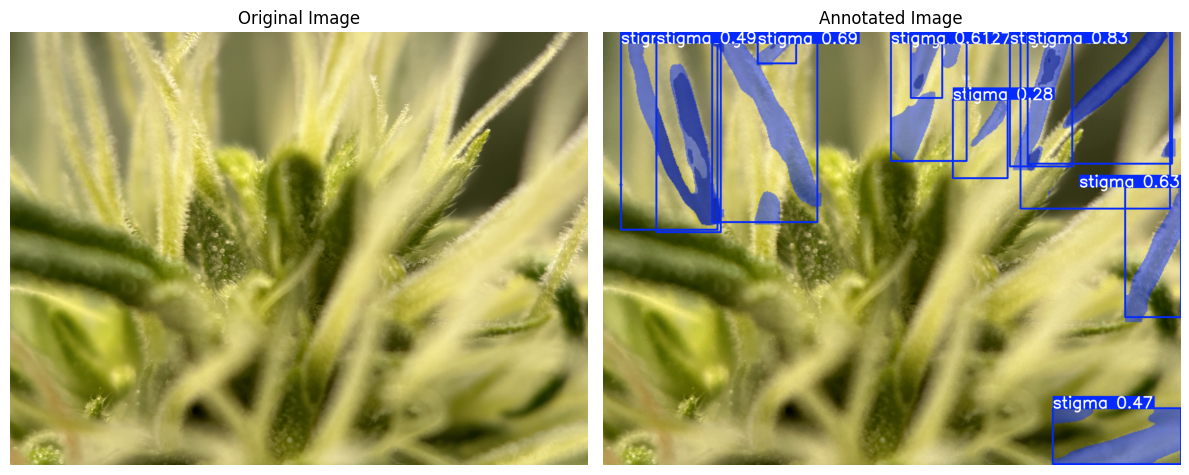

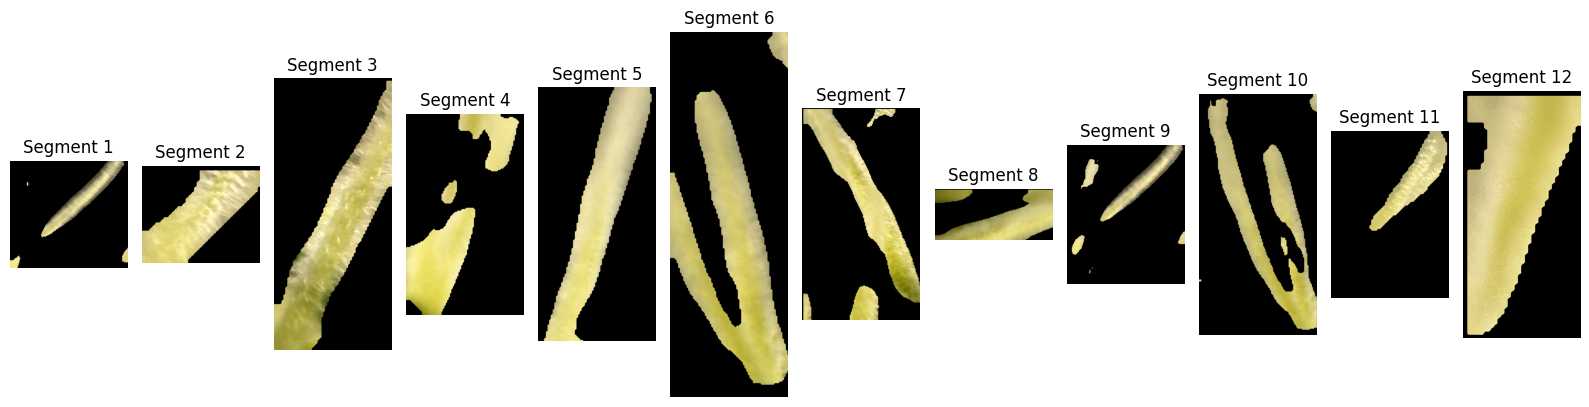


Pistil 1 Color Ratios (RGB):
  Orange-Brown: 49.48%
  Green:        50.52%

Pistil 2 Color Ratios (RGB):
  Orange-Brown: 100.00%
  Green:        0.00%

Pistil 3 Color Ratios (RGB):
  Orange-Brown: 92.84%
  Green:        7.16%

Pistil 4 Color Ratios (RGB):
  Orange-Brown: 98.45%
  Green:        1.55%

Pistil 5 Color Ratios (RGB):
  Orange-Brown: 17.16%
  Green:        82.84%

Pistil 6 Color Ratios (RGB):
  Orange-Brown: 96.66%
  Green:        3.34%

Pistil 7 Color Ratios (RGB):
  Orange-Brown: 89.89%
  Green:        10.11%

Pistil 8 Color Ratios (RGB):
  Orange-Brown: 80.15%
  Green:        19.85%

Pistil 9 Color Ratios (RGB):
  Orange-Brown: 49.18%
  Green:        50.82%

Pistil 10 Color Ratios (RGB):
  Orange-Brown: 96.73%
  Green:        3.27%

Pistil 11 Color Ratios (RGB):
  Orange-Brown: 100.00%
  Green:        0.00%

Pistil 12 Color Ratios (RGB):
  Orange-Brown: 0.00%
  Green:        0.00%


In [17]:
# Example usage:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/experiment_1/images/day_1_2024_05_30/greenhouse/26/IMG_4967.JPG"
segmented_stigmas_save_dir = "/path/to/save/segmented_pistils"

# `model` is your loaded YOLO model
segmented_objects = run_stigma_segmentation_pipeline(
    image_path=image_path,
    model=model,
)